In [45]:
import datetime
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
matplotlib.use('Agg')
%matplotlib inline
from dateutil.relativedelta import relativedelta

from finrl.apps import config
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline, get_baseline_tdx,convert_daily_return_to_pyfolio_ts

import torch
# import plotly.express as px

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import EfficientFrontier
from pypfopt import expected_returns
from pypfopt import objective_functions
from pyfolio import timeseries

import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
from lutils.stock import LTdxHq

In [3]:
train_start = '2019-01-01'
train_end = '2022-01-01'
trade_start = train_end
trade_end = '2022-01-09'

In [4]:
ddf = pd.read_pickle('d:/ddf.pkl').dropna()

In [5]:
ddf = ddf.sort_values(['date','tic'], ignore_index=True)
ddf.index = ddf.date.factorize()[0]

In [6]:
days = ddf.date.unique()
days.shape

(1472,)

In [7]:
dl = ddf[(ddf['date'] > days[-50]) & (ddf['date'] < trade_start)]
dd = dl.pivot_table(index = 'date',columns = 'tic', values = 'close').pct_change().dropna()
corr = dd.cov().corr()
# corr.style.background_gradient(cmap='coolwarm')

# c1 = corr.abs().unstack().sort_values(ascending = True)
# c1 = corr.unstack().sort_values(ascending = True)

In [8]:
# corr.style.background_gradient(cmap='coolwarm')

In [9]:
corr.sum().sort_values()

tic
601868   -391.795383
000501   -359.562950
603789   -358.643705
002311   -349.088371
002873   -334.020202
             ...    
002962    738.591688
603528    739.010659
300711    742.481668
002866    758.208425
300637    767.312419
Length: 2376, dtype: float64

In [10]:
stock_codes = list(corr.sum().sort_values().index.values[:6]) 
# ['000921', '600365', '000609', '601868', '002372', '001965']
# ['601868', '000501', '603789', '002311', '002873', '000921']

In [11]:
stock_codes

['601868', '000501', '603789', '002311', '002873', '000921']

In [12]:
# stock_codes = ['000921', '002032', '300406', '603789']
# stock_codes = ['000609', '000921', '001965', '002372']

In [13]:
ltdxhq = LTdxHq()

indexs = None
dfs = []
for code in stock_codes:
    df = ltdxhq.get_k_data_daily(code, start='2018-01-01') # 2014-01-01
    
    if indexs is None:
        indexs = df.index
    else:
        indexs = indexs.union(df.index)
    
#     df = df.assign(date = df.index)
#     df = df.assign(day = df.index.weekday)
#     df.date = df.date.dt.strftime('%Y-%m-%d')
    df = df.assign(tic = code)
#     df.index = range(df.shape[0])
    
    dfs.append(df)
    print('----------- over %s min: %s max: %s -----------' % (code, df.index.min(), df.index.max()))

for i, df in enumerate(dfs):
    df = df.reindex(indexs)
    df = df.assign(date = df.index)
    df = df.assign(day = df.index.weekday)
    df.index = range(df.shape[0])
    
    dfs[i] = df.ffill()
    
df = pd.concat(dfs)
# df.index = range(df.shape[0])

ltdxhq.close()

----------- over 601868 min: 2021-09-28 00:00:00 max: 2022-01-20 00:00:00 -----------
----------- over 000501 min: 2018-01-02 00:00:00 max: 2022-01-20 00:00:00 -----------
----------- over 603789 min: 2018-01-02 00:00:00 max: 2022-01-20 00:00:00 -----------
----------- over 002311 min: 2018-01-02 00:00:00 max: 2022-01-20 00:00:00 -----------
----------- over 002873 min: 2018-01-02 00:00:00 max: 2022-01-20 00:00:00 -----------
----------- over 000921 min: 2018-01-02 00:00:00 max: 2022-01-20 00:00:00 -----------


In [72]:
df

,open,close,high,low,volume,amount,tic,date,day
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-02,1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-03,2
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-04,3
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-05,4
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-08,0
...,...,...,...,...,...,...,...,...,...
981,15.77,15.96,16.35,15.49,9313988.0,148198048.0,000921,2022-01-14,4
982,15.80,15.96,16.18,15.49,7857587.0,124451200.0,000921,2022-01-17,0
983,15.99,16.39,16.92,15.91,6709937.0,110802224.0,000921,2022-01-18,1
984,16.37,17.00,17.18,16.15,9604392.0,162159696.0,000921,2022-01-19,2


In [16]:
%matplotlib inline

In [20]:
df.columns

Index(['open', 'close', 'high', 'low', 'volume', 'amount', 'tic', 'date',
       'day'],
      dtype='object')

<AxesSubplot:>

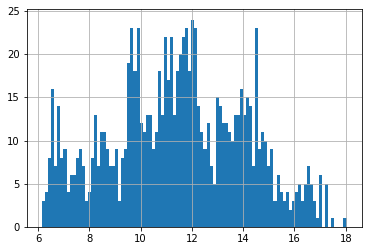

In [69]:
# hist = df[df.tic == '601868 '].close.hist() # bins=3)

# df[['open', 'close', 'high', 'low']].plot.hist(bins=100, alpha=0.5)
df[df.tic == '000921'].close.hist(bins=100)

d:\soft\python\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='close', ylabel='Density'>

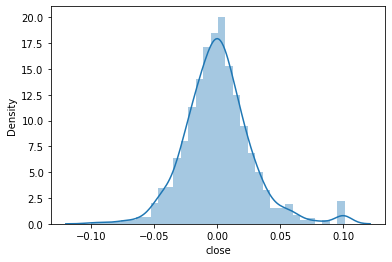

In [70]:
sns.distplot(df[df.tic == '000921'].close.pct_change())

In [71]:
stat, p = shapiro(df[df.tic == '000921'].close.pct_change())
stat, p

(nan, 1.0)

In [14]:
fe = FeatureEngineer(use_technical_indicator=True,
                     use_turbulence=False,
                     user_defined_feature = False)

df = fe.preprocess_data(df)

Successfully added technical indicators


In [15]:
# add covariance matrix as states
df=df.sort_values(['date','tic'], ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback=252
for i in range(lookback, len(df.index.unique())):
    data_lookback = df.loc[i-lookback:i, :]
    price_lookback = data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
    return_lookback = price_lookback.pct_change().dropna()
    return_list.append(return_lookback)

    covs = return_lookback.cov().values
    cov_list.append(covs)


df_cov = pd.DataFrame({'date': df.date.unique()[lookback:], 'cov_list': cov_list,'return_list': return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date', 'tic']).reset_index(drop = True)

In [16]:
df['daily_variance'] = (df.high-df.low) / df.close

In [17]:
dl = df.loc[-5:, :]
dd = dl.pivot_table(index = 'date',columns = 'tic', values = 'close').pct_change().dropna()
dd.cov().corr().style.background_gradient(cmap='coolwarm')

tic,000501,000921,002311,002873,603789
tic,,,,,
000501,1.000000,-0.027047,-0.313474,-0.182205,-0.188698
000921,-0.027047,1.000000,0.053127,-0.171162,-0.393731
002311,-0.313474,0.053127,1.000000,-0.318748,-0.467323
002873,-0.182205,-0.171162,-0.318748,1.000000,-0.324858
603789,-0.188698,-0.393731,-0.467323,-0.324858,1.000000


In [18]:
train = data_split(df, train_start, train_end) # 2021-07-01 2022-01-01

In [19]:
train.head()

,open,close,high,low,volume,amount,tic,date,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list,daily_variance
0,9.55,9.60,9.63,9.51,2015977.0,20242538.0,000501,2019-01-15,1,0.018715,9.723275,8.809725,51.465328,71.206744,15.686791,9.369333,9.475667,"[[0.000356668511816183, 0.0002731930235242828,...",tic 000501 000921 002311 00...,0.012500
0,7.34,7.55,7.55,7.22,20004778.0,161089488.0,000921,2019-01-15,1,0.171956,7.579382,5.955618,57.955100,171.516755,60.304291,6.799667,6.725167,"[[0.000356668511816183, 0.0002731930235242828,...",tic 000501 000921 002311 00...,0.043709
0,22.12,22.42,22.47,21.94,2060044.0,46871728.0,002311,2019-01-15,1,0.014409,22.795027,21.517973,53.244275,-33.075161,7.010660,22.532333,21.747167,"[[0.000356668511816183, 0.0002731930235242828,...",tic 000501 000921 002311 00...,0.023640
0,11.26,11.35,11.38,11.17,510531.0,8203724.5,002873,2019-01-15,1,-0.033568,11.721703,10.902297,46.394814,-15.535568,25.616040,11.339000,11.525167,"[[0.000356668511816183, 0.0002731930235242828,...",tic 000501 000921 002311 00...,0.018502
0,12.65,12.68,12.74,12.56,1578860.0,20004332.0,603789,2019-01-15,1,0.051433,12.724760,12.095240,54.999159,120.777027,21.967151,12.418000,12.562833,"[[0.000356668511816183, 0.0002731930235242828,...",tic 000501 000921 002311 00...,0.014196


In [20]:
train[train['cci_30'] == -np.inf]

,open,close,high,low,volume,amount,tic,date,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list,daily_variance


In [21]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv


class StockPortfolioEnv(gym.Env):
    """A portfolio allocation environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self,
                 df,
                 stock_dim,
                 hmax,
                 initial_amount,
                 transaction_cost_pct,
                 reward_scaling,
                 state_space,
                 action_space,
                 tech_indicator_list,
                 turbulence_threshold=None,
                 lookback=252,
                 day=0):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.lookback=lookback
        self.df = df
        self.stock_dim = stock_dim
        self.hmax = hmax
        self.initial_amount = initial_amount
#         self.reward = initial_amount
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space = state_space
        self.action_space = action_space
        self.tech_indicator_list = tech_indicator_list

        # action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low=0, high=1,shape=(self.action_space,))
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.terminal = False
        self.turbulence_threshold = turbulence_threshold
        # initalize state: inital portfolio return + individual stock return + individual weights
        self.portfolio_value = self.initial_amount

        # memorize portfolio value each step
        self.asset_memory = [self.initial_amount]
        # memorize portfolio return each step
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1 / self.stock_dim] * self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique()) - 1

        if self.terminal:
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
#             plt.plot(df.daily_return.cumsum(),'r')
#             plt.savefig('results/cumulative_reward.png')
#             plt.close()
            
#             plt.plot(self.portfolio_return_memory,'r')
#             plt.savefig('results/rewards.png')
#             plt.close()

            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))
            print("end_total_asset:{}".format(self.portfolio_value))

            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() != 0:
                sharpe = (252 ** 0.5) * df_daily_return['daily_return'].mean() / df_daily_return['daily_return'].std()
                print("Sharpe: ", sharpe)
            print("=================================")
            
            return self.state, self.reward, self.terminal,{}

        else:
            weights = self.softmax_normalization(actions)
            self.actions_memory.append(weights)
            last_day_memory = self.data

            #load next state
            self.day += 1
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state = np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list], axis=0)
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values) - 1) * weights)
#             log_portfolio_return = np.log(sum((self.data.close.values / last_day_memory.close.values) * weights))
            # update portfolio value
            new_portfolio_value = self.portfolio_value * (1 + portfolio_return)
#             new_portfolio_value = self.portfolio_value * (1 + log_portfolio_return)
            self.portfolio_value = new_portfolio_value

            # save into memory
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])
            self.asset_memory.append(new_portfolio_value)

            # the reward is the new portfolio value or end portfolo value
            self.reward = new_portfolio_value / self.initial_amount

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.day = 0
        self.data = self.df.loc[self.day, :]
        # load states
        self.covs = self.data['cov_list'].values[0]
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        self.portfolio_value = self.initial_amount
        #self.cost = 0
        #self.trades = 0
        self.terminal = False
        self.portfolio_return_memory = [0]
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.date_memory=[self.data.date.unique()[0]]
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        numerator = np.exp(actions)
        denominator = np.sum(np.exp(actions))
        softmax_output = numerator / denominator
        return softmax_output

    
    def save_asset_memory(self):
        date_list = self.date_memory
        portfolio_return = self.portfolio_return_memory
        #print(len(date_list))
        #print(len(asset_list))
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
        return df_account_value

    def save_action_memory(self):
        # date and close price length must match actions length
        date_list = self.date_memory
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date
        #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [22]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f'Stock Dimension: {stock_dimension}, State Space: {state_space}')

Stock Dimension: 5, State Space: 5


In [23]:
# ['daily_variance', 'change', 'log_volume', 'close','day', 'macd', 'rsi_30', 'boll_ub', 'dx_30']
# ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'boll_ub', 'dx_30', 'close_30_sma', 'close_60_sma'] # cci_30
tech_indicator_list = ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'daily_variance', 'dx_30', 'close_30_sma', 'close_60_sma']
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 100000, 
    "transaction_cost_pct": 0, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": tech_indicator_list, # config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-1
    
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)

In [24]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [25]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo", model_kwargs = PPO_PARAMS, tensorboard_log='D:/code/python/logs')

{'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.0001, 'batch_size': 128}
Using cuda device


In [26]:
agent.train_model(model=model_ppo, tb_log_name='ppo', total_timesteps=40000)

d:\soft\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\soft\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\soft\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\soft\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (

Logging to D:/code/python/logs\ppo_9
begin_total_asset:100000
end_total_asset:227970.3672485239
Sharpe:  1.3329482388311538
begin_total_asset:100000
end_total_asset:189091.54601758177
Sharpe:  1.0451064093333882
---------------------------------
| time/              |          |
|    fps             | 423      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
| train/             |          |
|    reward          | 1.954504 |
---------------------------------
begin_total_asset:100000
end_total_asset:231362.45382684164
Sharpe:  1.3671677894981646
begin_total_asset:100000
end_total_asset:205813.33930170356
Sharpe:  1.185445173127
begin_total_asset:100000
end_total_asset:247427.96806306377
Sharpe:  1.439287724192685
------------------------------------------
| time/                   |              |
|    fps                  | 458          |
|    iterations           | 2            |
|    time_elapsed         | 8            |
|    tot

begin_total_asset:100000
end_total_asset:194253.58988844193
Sharpe:  1.1046288482291886
begin_total_asset:100000
end_total_asset:155939.33000275475
Sharpe:  0.7722250187579982
begin_total_asset:100000
end_total_asset:170429.0964975249
Sharpe:  0.9183483868909168
-----------------------------------------
| time/                   |             |
|    fps                  | 484         |
|    iterations           | 8           |
|    time_elapsed         | 33          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.004838462 |
|    clip_fraction        | 0.0199      |
|    clip_range           | 0.2         |
|    entropy_loss         | -7.12       |
|    explained_variance   | 0.0309      |
|    learning_rate        | 0.0001      |
|    loss                 | 206         |
|    n_updates            | 70          |
|    policy_gradient_loss | -0.00921    |
|    reward               | 1.912761    |
|    std               

------------------------------------------
| time/                   |              |
|    fps                  | 486          |
|    iterations           | 14           |
|    time_elapsed         | 58           |
|    total_timesteps      | 28672        |
| train/                  |              |
|    approx_kl            | 0.0041199885 |
|    clip_fraction        | 0.0145       |
|    clip_range           | 0.2          |
|    entropy_loss         | -7.11        |
|    explained_variance   | 0.00816      |
|    learning_rate        | 0.0001       |
|    loss                 | 217          |
|    n_updates            | 130          |
|    policy_gradient_loss | -0.011       |
|    reward               | 2.063449     |
|    std                  | 1            |
|    value_loss           | 469          |
------------------------------------------
begin_total_asset:100000
end_total_asset:214982.0852259103
Sharpe:  1.2407208854957068
begin_total_asset:100000
end_total_asset:179196.07093

In [39]:
trade = data_split(df, trade_start, trade_end) # '2021-12-20', '2023-01-01' trade_start, trade_end
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)

In [40]:
unique_tic = trade.tic.unique()
unique_trade_date = trade.date.unique()

In [47]:
df_daily_return_ppo, df_actions_ppo = DRLAgent.DRL_prediction(model=model_ppo, environment=e_trade_gym)
time_ind = pd.Series(df_daily_return_ppo.date)
ppo_cumpod =(df_daily_return_ppo.daily_return + 1).cumprod() - 1
DRL_strat_ppo = convert_daily_return_to_pyfolio_ts(df_daily_return_ppo)

perf_func = timeseries.perf_stats 

perf_stats_all_ppo = perf_func(returns=DRL_strat_ppo, 
                               factor_returns=DRL_strat_ppo, 
                               positions=None, transactions=None, turnover_denom='AGB')

begin_total_asset:100000
end_total_asset:97675.50159918507
Sharpe:  -23.659318058697412
hit end!
